<a href="https://colab.research.google.com/github/Jussara-S-Silva/Machine-Learning/blob/main/Projeto_Machine_Learning_para_Diagn%C3%B3stico_de_C%C3%A2ncer_de_Mama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning para Diagnóstico de Câncer de Mama

Este projeto tem como finalidade apresentar os conhecimentos que adqueri através das aulas e artigos do Professor Carlos Melo pelo Blog Sigmoidal

* **[Link para o blog Sigmoidal](https://sigmoidal.ai/)**

Neste projeto usaremos a linguagem Python, bibliotecas e dataframes para desenvolver um projeto de *Machine Learning* que irá analisar os dados e atribuir o diagnóstico de M - Maligno ou B - Benigno.

*Data Science* está sendo muito utilizada na medicina, inclusive para a detecção do câncer de mama vem crescendo cada vez mais, e contribuído para diagnósticos mais rápidos e precisos.

## Importar os Dados

Na construção deste modelo de *Machine Learning* foi usado o banco de dados Wisconsin, disponibilizado no [Repositório de Machine Learning da UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


sns.set_style()

In [ ]:
# Dataset em csv 
data_path = "https://www.dropbox.com/s/z8nw6pfumdw3bb9/breast-cancer-wisconsin.csv?raw=1" 
df = pd.read_csv(data_path)

# Excluir coluna com erro
df.drop('Unnamed: 32', axis=1, inplace=True)

## Análise Exploratória

Iremos examinar as dimensões do DataFrame e as primeiras entradas. Isso possibilitará criar uma consciência situacional sobre o formato de entrada e da estrutura geral dos dados.

* A coluna `id` representa o valor de identificação.
* A coluna `diagnosis` é a variável em questão.
  * **M -** *Maligno*
  * **B -** *Benigno*


In [ ]:
# dimensões do df
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

DIMENSÕES DO DATAFRAME:
Linhas:		569
Colunas:	32


Vejamos as 5 primeiras entradas para visualizar inicialmente sobre o tipo de formato e criar hipóteses iniciais do processo investigativo.

In [ ]:
# ver as 5 primeiras entradas
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Através do Describe veremos resumo estatístico das variáveis numéricas.

In [ ]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Mesmo todos os valores sendo numéricos, particularmente eu gosto de verificar a quantidade de valores únicos para cada *feature*, pois isso permite verificar se os números podem estar representando classes, por exemplo.

In [ ]:

print("\nVALORES ÚNICOS:")
print(df.nunique().sort_values())


VALORES ÚNICOS:
diagnosis                    2
smoothness_worst           411
symmetry_mean              432
radius_mean                456
radius_worst               457
smoothness_mean            474
texture_mean               479
concave points_worst       492
symmetry_se                498
fractal_dimension_mean     499
symmetry_worst             500
concave points_se          507
texture_worst              511
perimeter_worst            514
texture_se                 519
perimeter_mean             522
area_se                    528
compactness_worst          529
perimeter_se               533
concavity_se               533
fractal_dimension_worst    535
concavity_mean             537
compactness_mean           537
concavity_worst            539
area_mean                  539
radius_se                  540
compactness_se             541
concave points_mean        542
area_worst                 544
fractal_dimension_se       545
smoothness_se              547
id                    

O *dataset* apresenta a porcentagem de valores da variável em questão, que tem mais valores Benignos do que Malignos.

Diagnósticos:
B    0.627417
M    0.372583
Name: diagnosis, dtype: float64


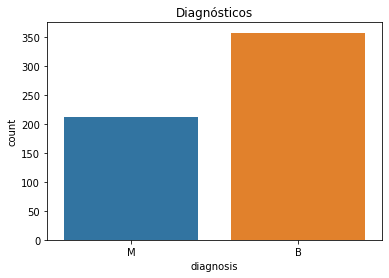

In [ ]:
# ver porcentagem dos diagnósticos
print("Diagnósticos:")
print(df.diagnosis.value_counts() / df.shape[0])

# plotar o gráfico de barras com os diagnósticos
fig, ax = plt.subplots()
sns.countplot('diagnosis', data=df, ax=ax)
ax.set_title("Diagnósticos")
plt.show()

## Preparação dos dados

Como parte do pré-processamento dos dados, que irão alimentar o modelo de *Machine Learning*, vou usar o `StardardScaler`, que vem junto com `sklearn.preprocessing`, para padronizar nossos dados numéricos.

A nossa variável alvo é categórica, onde *M* representa os tumores malignos e *B* os benignos. Usando `LabelEncoder` com a finalidade de converter variáveis categóricas em numéricas e alimentar o modelo adequadamente.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# separar as variáveis independentes da variável alvo
X = df.drop(['diagnosis', 'id'], axis=1)
y = df['diagnosis']

# padronizar as colunas numéricas
X = StandardScaler().fit_transform(X)

# label encoder na variável alvo
y = LabelEncoder().fit_transform(y)

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

O cálculo utilizar por `StandardScaler` para calcular os *scores* é $z = \frac{x-u}{s}$, onde $u$ é a média das amostras do conjunto de treino e $s$ é o desvio padrão dessa amostra.

Dividimos o *dataset* entre treino e teste usando o `train_test_split`, função que facilitar muito o trabalho, e que se encontra em `sklearn.model_selection`.

## Modelo de Machine Learning para detecção do câncer de mama

Este problema de detecção de câncer consiste em classificar corretamente um tumor entre benigno e maligno, ou seja, é necessário que o modelo de *Machine Learning* dê uma classificação ao ser alimentado com diversas variáveis independentes (*features*).

Aqui, usarei um modelo do tipo *Random Forest* (Floresta Aleatória) devido à sua flexibilidade e facilidade de uso (uma vez que funciona muito bem mesmo sem o ajuste nos hiperparâmetros).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# instanciando o modelo de Random Forest
ml_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
                                  random_state = 42)

# treinando o modelo 
ml_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Desempenho do modelo de detecção de câncer de mama

Aqui, além da métrica de acurácia também inserimos a função `classification_report` para ver ver o desempenho do modelo sobre as métricas de precisão, *recall*, *f1-score* e *support*.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# realizar as previsões no dataset de teste
y_pred = ml_model.predict(X_test)

# ver acurácia geral
print('[Acurácia] Random Forest:', accuracy_score(y_test, y_pred))

# imprimir o classification report
print('\n[Classification Report] Random Forest')
print( classification_report(y_test, y_pred) )

[Acurácia] Random Forest: 0.9649122807017544

[Classification Report] Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       111
           1       1.00      0.90      0.95        60

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



A matriz de confusão permitirá visualizar a acurácia deste modelo.

In [ ]:
# plotar a matriz de confusão
pd.DataFrame(confusion_matrix(y_test, y_pred),
             index=['neg', 'pos'], columns=['pred_neg', 'pred_pos'])

,pred_neg,pred_pos
neg,111,0
pos,6,54


Podemos ver que o modelo classificatório Random Forest atingiu uma acurácia superior a 96% e lidou muito bem com ambas classificações.